In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, style

style.use('ggplot')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Анализ имеющихся  признаков

#### Для начала посмотрим что из себя представляет датасет:

In [3]:
df.shape

(891, 12)

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Из статистики в тренировочном и тестовом детасетах становится понятно, что есть опреденные проблемы с категориями Age, Fare и Cabin, где есть отсутствующие значения, при анализе надо это учитывать. 

In [8]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


<ul>
<li>PassengerId - Идентификатор пассажира. Вряд ли от него можно получить какую-то пользу.</li>
<li>Survived - Целевая переменная выжил/невыжил, которую надо найти - бинарный признак.</li>
<li>Pclass - Пассажирский класс - количественный признак (1 - первый; 2 - второй; 3 - третий).</li>
<li>Name - Имя пассажира - категориальный признак.</li>
<li>Sex - Пол пассажира - категориальный признак, который можно преобразовать в бинарный.</li>
<li>Age - Возраст пассажира - количественный признак.</li>
<li>SibSp - Количество братьев/сестер на борту коробля - количественный признак.</li>
<li>Parch - Количество родителей/детей на борту коробля - количественный признак.</li>
<li>Ticket - Номер билета - категориальный признак.</li>
<li>Fare - Цена билета - количественный признак.</li>
<li>Cabin - Номера каюты - категориальный признак.</li>
<li>Embarked - Место посадки (C - Cherbourg; Q - Queenstown; S - Southampton) - категориальный признак.</li>
</ul>

### Проведем небольшой анализ данных, чтобы понять какие нужны и как их лучше преобразовать

#### Для начала посмотрим распреденение погибших и выживших:

In [9]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

#### Теперь посмотрим  распреденение погибших и выживших по полу, для этого преобразуем категориальный признак в количественный:

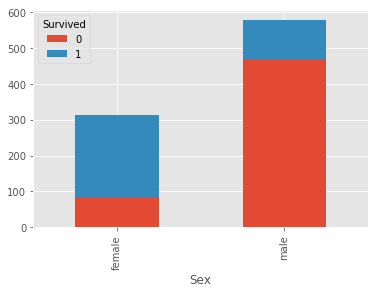

In [10]:
df.groupby(['Sex', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

Как видно, что в процентном соотношении, женщин погибло гораздо меньше чем мужчин. Возьмем этот факт на заметку.

#### Теперь посмотрим распреденение по классу:

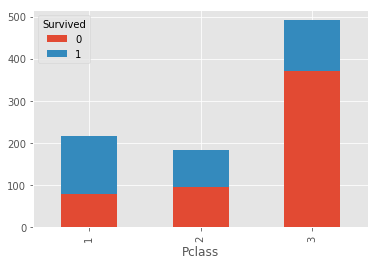

In [11]:
df.groupby(['Pclass', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

Видно, что в 1-ом (самом дорогом и самом близким к палубе) классе выживших больше всего, тогда как в 3-м ситуация ровно противоположная.

#### Проверим, стоит ли использовать категорию Fare или лучше ориентироваться на класс:

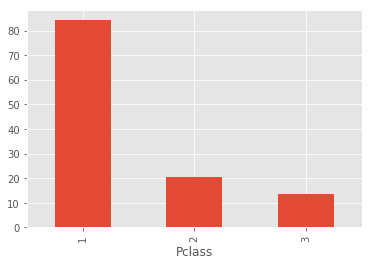

In [12]:
df.groupby('Pclass')['Fare'].mean().plot(kind='bar');

In [13]:
df.groupby('Pclass')['Fare'].max()

Pclass
1    512.3292
2     73.5000
3     69.5500
Name: Fare, dtype: float64

In [14]:
df[df['Fare'] > 0].groupby('Pclass')['Fare'].min()

Pclass
1     5.0000
2    10.5000
3     4.0125
Name: Fare, dtype: float64

Несмотря на то, что в среднем билеты 1-го класса стоят намного дороже чем 2-го и 3-го, но наблдается большая разница между самым дорогим и самым дешевым билетом, особенно в 1-ом классе. Пока непонятно что делать с этим признаком.

#### Теперь посмотрим на влияние наличия/отсутствия родственников:

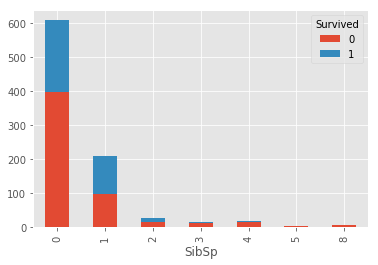

In [15]:
df.groupby(['SibSp', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

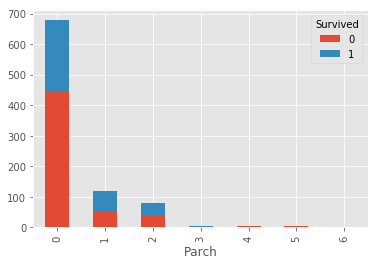

In [16]:
df.groupby(['Parch', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

Как видно, наличие хотя бы одного родственника на борту несколько повышает шанс на спасение. Попробуем добвить еще и пол к этим графикам.

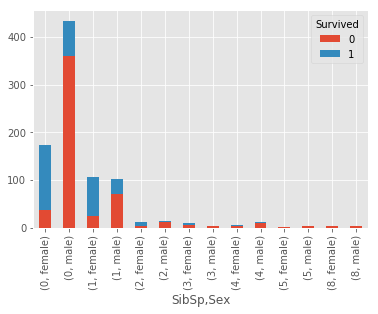

In [17]:
df.groupby(['SibSp', 'Sex', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

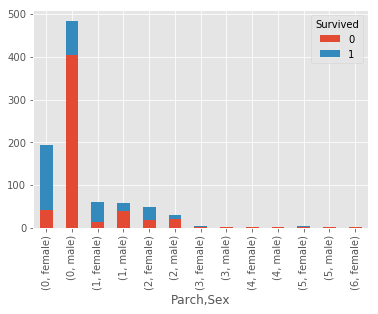

In [18]:
df.groupby(['Parch', 'Sex', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

Как видно, наличие родственников на борту лучше сказывается на женщинах, чем мужчинах. Поробуем установить родственные связи, для этого выделим фамилию в отдельный признак и посмотрим, что получится.

In [19]:
df['Surname'] = df['Name'].map(lambda name: name.split(',')[0].strip())
df[(df['SibSp'] > 0) | (df['Parch'] > 0)].sort_values(['Surname']).head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.2500,NaN,S,Abbott
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.2500,NaN,S,Abbott
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.00,1,0,P/PP 3381,24.0000,NaN,C,Abelson
308,309,0,2,"Abelson, Mr. Samuel",male,30.00,1,0,P/PP 3381,24.0000,NaN,C,Abelson
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.4750,NaN,S,Ahlin
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.00,0,1,392091,9.3500,NaN,S,Aks
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,Allison
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,Allison
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,Allison
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.00,1,0,350046,7.8542,NaN,S,Andersen-Jensen


Можно заметить, что наличие родственников можно определить не только по фамилий, но и (вполне возможно), что и по единому номеру билета. С другой стороны, не для всех пассажиров указаны все родственники (как для фамилии Aks или Ahlin), возможно это связано с разделением на тестовую и тренировочную выборки, поэтому это не может являться надежной категорией для исследования. С другой стороны, наличия родителя Parch и возраст, скажем, до 6-ти лет, может довольно четко дать понять, что это ребенок с родителями. Проверим это предположение.

In [20]:
IS_CHILD_AGE = 6

In [21]:
df[(df['Parch'] > 0) & (df['Age'] <= IS_CHILD_AGE)]['Survived'].value_counts(normalize=True)

1    0.695652
0    0.304348
Name: Survived, dtype: float64

In [22]:
df[df['Age'] <= IS_CHILD_AGE]['Survived'].value_counts(normalize=True)

1    0.702128
0    0.297872
Name: Survived, dtype: float64

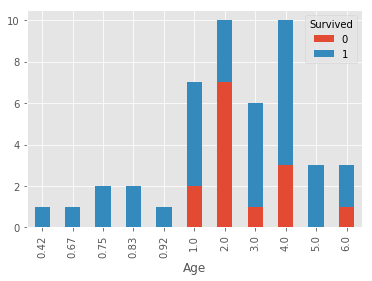

In [23]:
df[(df['Parch'] > 0) & (df['Age'] <= IS_CHILD_AGE)] \
    .groupby(['Age', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

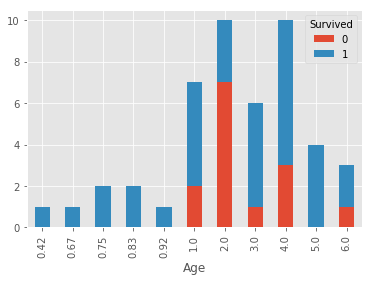

In [24]:
df[df['Age'] <= IS_CHILD_AGE] \
    .groupby(['Age', 'Survived']).size().unstack().plot(kind='bar', stacked=True);

Как видно, для ребенка более важен параметр возраста, а параметр Parch особой роли не играет.

In [25]:
df['IsChild'] = df.apply(lambda row: 1 if row['Age'] <= IS_CHILD_AGE else 0, axis=1)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,IsChild
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Moran,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,McCarthy,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Palsson,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Johnson,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Nasser,0


In [26]:
df[df['Parch'] > 0]['Survived'].value_counts(normalize=True)

1    0.511737
0    0.488263
Name: Survived, dtype: float64

Как можно заметить, наличие родителей или детей в определенной степени также повышает вероятность выжить, поэтому будем учитывать и этот признак тоже.

#### Раз уж затронули тему возраста, то исследуем еще и распределение по нему:

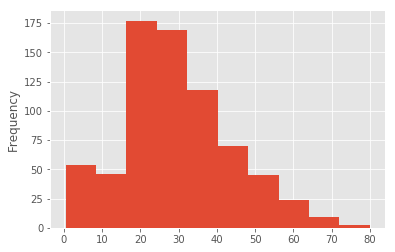

In [27]:
df['Age'].plot(kind='hist')

In [28]:
df['Age'].mean()

29.69911764705882

Так как напрямую работать с возрастом не очень удобно, то разобьем его на группы. А отсутствующие значения заменим нулями.

In [29]:
df['AgeGroup'] = df['Age']
df['AgeGroup'] = df['AgeGroup'].fillna(0).map(lambda age: int(age // 10) + 1)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,IsChild,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,0,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,0,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,0,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,0,4
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Moran,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,McCarthy,0,6
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Palsson,1,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Johnson,0,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Nasser,0,2


In [30]:
df['AgeGroup'].value_counts()

1    239
3    220
4    167
2    102
5     89
6     48
7     19
8      6
9      1
Name: AgeGroup, dtype: int64

Получились следующие группы 0 - для тех у кого возраст не указан, 1 - возраст от 0 до 9 лет, 2 - от 10 до 19 и т.д. Из них - самая многочисленная группа 3 - от 20 до 29 лет.

#### В итоге, после краткого анализа можно определиться со следующими признаками, которые могут оказать влияние на качество обучения:

<ul>
<li>Pclass - Пассажирский класс - количественный признак (1 - первый; 2 - второй; 3 - третий).</li>
<li>Age - Возраст пассажира - количественный признак.</li>
<li>Sex - Пол пассажира - бинарный признак.</li>
<li>Parch - Количество родителей/детей на борту коробля - количественный признак.</li>
<li>IsChild - Является ли пассажир ребенком - бинарный признак.</li>
<li>AgeGroup - Возрастная группа пассажира - порядковый признак в дополнение к Age.</li>
</ul>

#### Оставим еще следующие признаки, которые, теоретически, должны улучшить результат:

<ul>
<li>SibSp - Количество братьев/сестер на борту коробля - количественный признак.</li>
<li>Fare - Цена билета - количественный признак.</li>
</ul>

### Создадим Pipeline для преобразования данных и для используемых моделей

#### для начала создадим Pipeline для обработки данных:

In [31]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Imputer

In [32]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [33]:
class AgeGroup(LabelEncoder):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X = np.squeeze(np.asarray(X))
        v = np.array([10] * X.shape[0])
        X = np.sum([np.array([1] * X.shape[0]), np.divide(X, v)], axis=0).astype(int)
        return X.reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.transform(X)

In [34]:
class IsChild(LabelEncoder):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        d = np.zeros(X.shape[0])
        child_idx = np.where(X[:,0] <= IS_CHILD_AGE)
        np.put(d, child_idx, 1)
        return d.reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.transform(X)

In [35]:
def get_sex_col(df):
    return df[['Sex']]

def get_age_col(df):
    return df[['Age']]

def get_fare_col(df):
    return df[['Fare']]

def get_sibsp_parch_pclass_col(df):
    return df[['SibSp', 'Parch', 'Pclass']]

pipe = make_union(*[
    make_pipeline(FunctionTransformer(get_sex_col, validate=False), LabelEncoderPipelineFriendly()),
    make_pipeline(FunctionTransformer(get_age_col, validate=False), Imputer(strategy='mean')),
    make_pipeline(FunctionTransformer(get_age_col, validate=False), Imputer(strategy='mean'), IsChild()),
    make_pipeline(FunctionTransformer(get_age_col, validate=False), Imputer(strategy='mean'), AgeGroup()),
    make_pipeline(FunctionTransformer(get_fare_col, validate=False), Imputer(strategy='mean')),
    make_pipeline(FunctionTransformer(get_sibsp_parch_pclass_col, validate=False), Imputer(strategy='most_frequent')),
])

In [36]:
X_train = pipe.fit_transform(df)

/Users/andrewlarin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andrewlarin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
X_train[:10]

array([[  1.        ,  22.        ,   0.        ,   3.        ,
          7.25      ,   1.        ,   0.        ,   3.        ],
       [  0.        ,  38.        ,   0.        ,   4.        ,
         71.2833    ,   1.        ,   0.        ,   1.        ],
       [  0.        ,  26.        ,   0.        ,   3.        ,
          7.925     ,   0.        ,   0.        ,   3.        ],
       [  0.        ,  35.        ,   0.        ,   4.        ,
         53.1       ,   1.        ,   0.        ,   1.        ],
       [  1.        ,  35.        ,   0.        ,   4.        ,
          8.05      ,   0.        ,   0.        ,   3.        ],
       [  1.        ,  29.69911765,   0.        ,   3.        ,
          8.4583    ,   0.        ,   0.        ,   3.        ],
       [  1.        ,  54.        ,   0.        ,   6.        ,
         51.8625    ,   0.        ,   0.        ,   1.        ],
       [  1.        ,   2.        ,   1.        ,   1.        ,
         21.075     ,   3.       

In [38]:
y_train = df['Survived']
y_train[:10]

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

#### Теперь с помощью случайных лесов и градинетного бустинга посмотрим важность полученных признаков:

In [39]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 

In [40]:
df_tmp = df

df_tmp['SexCode'] = df_tmp['Sex'].map(lambda sex: 1 if sex == 'male' else 0)
df_tmp['AgeGroup'] = df_tmp['Age']
df_tmp['AgeGroup'] = df_tmp['AgeGroup'].fillna(0).map(lambda age: int(age // 10) + 1)

df_tmp = df_tmp[['SexCode', 'Age', 'IsChild', 'AgeGroup', 'Fare', 'SibSp', 'Parch', 'Pclass']]

df_tmp.head(5)

,SexCode,Age,IsChild,AgeGroup,Fare,SibSp,Parch,Pclass
0,1,22.0,0,3,7.2500,1,0,3
1,0,38.0,0,4,71.2833,1,0,1
2,0,26.0,0,3,7.9250,0,0,3
3,0,35.0,0,4,53.1000,1,0,1
4,1,35.0,0,4,8.0500,0,0,3


In [41]:
def plot_feature_importances(model, df):
    n_features = df.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")

In [42]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

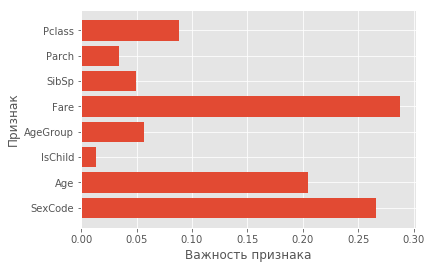

In [43]:
plot_feature_importances(forest, df_tmp)

In [44]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train) 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

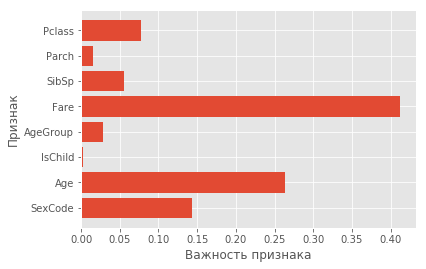

In [45]:
plot_feature_importances(gbrt, df_tmp)

Как видно, наименее значимый признак - IsChild, но, возможно, он добавит парочку очков нашей модели.

#### Теперь сделаем Pipeline для моделей, которые будем использовать и для которых надо масштабировать данные:

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 

In [47]:
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
pipe_knn.steps

[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('kneighborsclassifier',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'))]

In [48]:
pipe_logit = make_pipeline(StandardScaler(), LogisticRegression())
pipe_logit.steps

[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

### Протестируем модели на тренировочных данных

Поиск оптимальных значений параметров будем осуществлять с помощью класса GridSearchCV.

In [49]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

/Users/andrewlarin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/andrewlarin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### kNN:

In [50]:
n_neighbors_array = list(range(1, 10))
grid_knn = GridSearchCV(pipe_knn, param_grid={'kneighborsclassifier__n_neighbors': n_neighbors_array}, cv=10)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [51]:
print('kNN grid.best_score_', grid_knn.best_score_)
print('kNN grid.best_params_', grid_knn.best_params_)

kNN grid.best_score_ 0.8204264870931538
kNN grid.best_params_ {'kneighborsclassifier__n_neighbors': 7}


#### Логистическая регрессия:

In [52]:
grid_logit = GridSearchCV(pipe_logit, param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]}, cv=10)
grid_logit.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [53]:
print('Logit grid.best_score_', grid_logit.best_score_)
print('Logit grid.best_params_', grid_logit.best_params_)

Logit grid.best_score_ 0.8092031425364759
Logit grid.best_params_ {'logisticregression__C': 0.1}


#### Градиентный бустинг деревьев регрессии:

Так как для ансамблей моделей подбирать параметры более ресурсозатратно, вместо GridSearchCV будем использовать RandomizedSearchCV.

In [54]:
from sklearn.model_selection import RandomizedSearchCV

In [71]:
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.02, 0.05, 0.1]
}
grid_gbc = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='accuracy')
grid_gbc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [2, 3, 4, 5], 'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.01, 0.02, 0.05, 0.1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [72]:
print('Gradient Boosting grid.best_score_', grid_gbc.best_score_)
print('Gradient Boosting grid.best_params_', grid_gbc.best_params_)

Gradient Boosting grid.best_score_ 0.838383838384
Gradient Boosting grid.best_params_ {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05}


Не очень понятно, какой из алгоритмов предпочтительнее, поэтому попробуем все три (только для этого конкретного случая в учебных целях!).

### Запустим алгоритмы на тестовых данных

In [73]:
X_test = pipe.fit_transform(df_test)

/Users/andrewlarin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andrewlarin/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
X_test[:15]

array([[  1.        ,  34.5       ,   0.        ,   4.        ,
          7.8292    ,   0.        ,   0.        ,   3.        ],
       [  0.        ,  47.        ,   0.        ,   5.        ,
          7.        ,   1.        ,   0.        ,   3.        ],
       [  1.        ,  62.        ,   0.        ,   7.        ,
          9.6875    ,   0.        ,   0.        ,   2.        ],
       [  1.        ,  27.        ,   0.        ,   3.        ,
          8.6625    ,   0.        ,   0.        ,   3.        ],
       [  0.        ,  22.        ,   0.        ,   3.        ,
         12.2875    ,   1.        ,   1.        ,   3.        ],
       [  1.        ,  14.        ,   0.        ,   2.        ,
          9.225     ,   0.        ,   0.        ,   3.        ],
       [  0.        ,  30.        ,   0.        ,   4.        ,
          7.6292    ,   0.        ,   0.        ,   3.        ],
       [  1.        ,  26.        ,   0.        ,   3.        ,
         29.        ,   1.       

#### Создадим 2 предсказания для kNN и для логистической регрессии:

In [75]:
y_pred = grid_knn.predict(X_test)

In [76]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0,

In [77]:
df_predicted = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})

In [78]:
df_predicted.to_csv('sample_submission_knn.csv', sep=',', index=False)

In [79]:
y_pred = grid_logit.predict(X_test)

In [80]:
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [81]:
df_predicted = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})

In [82]:
df_predicted.to_csv('sample_submission_lr.csv', sep=',', index=False)

In [83]:
y_pred = grid_gbc.predict(X_test)

In [84]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [85]:
df_predicted = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})

In [86]:
df_predicted.to_csv('sample_submission_gbc.csv', sep=',', index=False)

В итоге, лучший результат для kaggle на текущий момент показан на логистической регрессии и равен 0.78468.